# Проектная работа: сборный проект №2

**Контекст:** для анализа предоставлены данные стартапа, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи мобильного приложения. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо проанализировать результат эксперимента.

## Загрузка данных

In [1]:
import re
import numpy as np
import math as mth
import pandas as pd
import datetime as dt
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

In [3]:
df = pd.read_csv('D:\\ds\\logs_exp.csv', sep='\t')
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 200)

In [4]:
def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

def prep(dataframe):
    dataframe = dataframe.drop_duplicates().reset_index(drop=True)
    dataframe.columns = [camel_to_snake(col) for col in dataframe.columns]
    dataframe.columns = dataframe.columns.str.replace(' ', '_')
    return dataframe

def get_info(dataframe):
    display(dataframe.head(5))
    print('*'*50)
    dataframe.info()
    print('*'*50)
    print(f"Явных дубликатов: {dataframe.duplicated().sum()}")
    print('*'*25)
    print('Пропусков в колонках:')
    print(dataframe.isna().sum())

## Предобработка

In [5]:
df = prep(df)
get_info(df)

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       243713 non-null  object
 1   device_id_hash   243713 non-null  int64 
 2   event_timestamp  243713 non-null  int64 
 3   exp_id           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.4+ MB
**************************************************
Явных дубликатов: 0
*************************
Пропусков в колонках:
event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64


Скорректирую формат времени, добавлю столбец даты и времени, а также отдельный столбец дат.

In [6]:
df['event_time'] = pd.to_datetime(df['event_timestamp'], unit='s')
df['event_dt'] = pd.to_datetime(df['event_time']).dt.date

Выполню проверку не пересекаются ли одинаковые id пользователей в разных группах.

In [7]:
id_doubles = df.groupby('device_id_hash')['exp_id'].nunique()
len(id_doubles[id_doubles > 1].index.tolist())

0

Таковых не обнаружено.

 ## Изучение данных

In [8]:
df['event_name'].nunique()

5

Всего в логе 5 уникальных событий.

In [9]:
df['device_id_hash'].nunique()

7551

Всего в логе 7551 уникальных пользователей.

In [10]:
df.groupby('device_id_hash')['event_name'].count().mean()

32.27559263673685

В среднем на одного пользователя приходится 32 события.

### Исследование временного периода

In [12]:
print(f"Минимальная дата: {df['event_time'].min()}")
print(f"Максимальная дата: {df['event_time'].max()}")
print(f"Период: {df['event_time'].max() - df['event_time'].min()}")

Минимальная дата: 2019-07-25 04:43:36
Максимальная дата: 2019-08-07 21:15:17
Период: 13 days 16:31:41


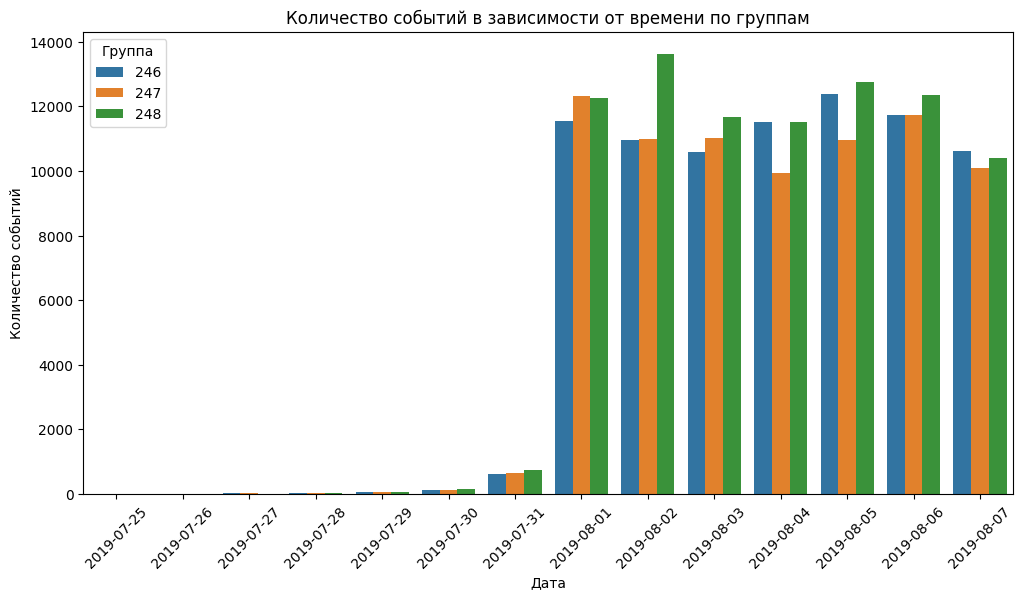

In [13]:
event_counts = df.groupby(['event_dt', 'exp_id'])['event_name'].count().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=event_counts, x='event_dt', y='event_name', hue='exp_id')
plt.title('Количество событий в зависимости от времени по группам')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)
plt.legend(title='Группа')
plt.show()

Судя по визуализации, актуальный период с полными данными следует определить начиная с 1 августа. 

In [14]:
df_unfilt = df.copy()
df = df.query('event_dt >= datetime(2019, 8, 1).date()')

In [15]:
print(f'Событий до фильтрации: {len(df_unfilt)}')
print(f'Событий после фильтрации: {len(df)}')
print(f'Доля удалённых событий: {((len(df_unfilt) - len(df)) / len(df_unfilt) * 100):.2f}%')
print()
print(f"Пользователей до фильтрации: {df_unfilt['device_id_hash'].nunique()}")
print(f"Пользователей после фильтрации: {df['device_id_hash'].nunique()}")
print("Доля удалённых пользователей: {:.2f}%".format(
    (df_unfilt['device_id_hash'].nunique() - df['device_id_hash'].nunique()) / df_unfilt['device_id_hash'].nunique() * 100))
print()
print('Количество пользователей по группам после фильтрации:\n', df.groupby('exp_id')['device_id_hash'].nunique())

Событий до фильтрации: 243713
Событий после фильтрации: 240887
Доля удалённых событий: 1.16%

Пользователей до фильтрации: 7551
Пользователей после фильтрации: 7534
Доля удалённых пользователей: 0.23%

Количество пользователей по группам после фильтрации:
 exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64


Отброшена незначительная часть данных, лог актуализирован, в выборке присутствуют все три группы.

 ## Изучение воронки событий

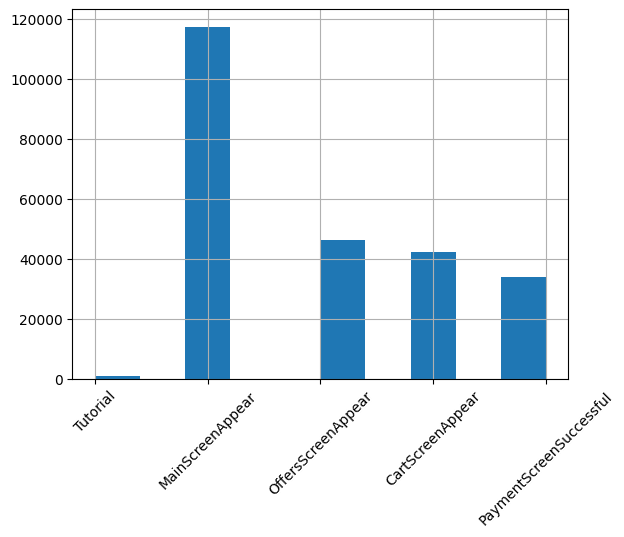

In [16]:
df['event_name'].hist()
plt.xticks(rotation=45);

Наскоро построенная гистограмма позволяет сразу оценить распределение событий по частоте встречаемости.

In [17]:
df.groupby('event_name')['device_id_hash'].count().sort_values(ascending=False)

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: device_id_hash, dtype: int64

- MainScreenAppear: просмотр главной страницы
- OffersScreenAppear: просмотр страницы с товаром
- CartScreenAppear: просмотр корзины покупок
- PaymentScreenSuccessful: просмотр страницы с совершённой покупкой
- Tutorial - просмотр обучающей информации

In [18]:
df_pivot = df.pivot_table(index='event_name', values='device_id_hash', aggfunc=['count', 'nunique'])
df_pivot.columns = ['total', 'uniques']
df_pivot['ratio'] = (df_pivot['uniques'] / (df['device_id_hash'].nunique()) * 100).apply(lambda x: f"{x:.2f}%")
df_pivot = df_pivot.sort_values(by='total', ascending=False)
df_pivot

,total,uniques,ratio
event_name,,,
MainScreenAppear,117328,7419,98.47%
OffersScreenAppear,46333,4593,60.96%
CartScreenAppear,42303,3734,49.56%
PaymentScreenSuccessful,33918,3539,46.97%
Tutorial,1005,840,11.15%


- в столбце total - общее количество событий 
- в столбце uniques - количество уникальных пользователей хотя бы раз совершивших событие 
- в столбце ratio - процентное соотношение уникальных пользователей, хотя бы раз совершавших событие, к общему количеству уникальных пользователей в датасете. 

Логичный порядок событий должен быть следующим: <br><br>
MainScreenAppear -> Tutorial -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful<br><br>
В данном случае обучающий раздел выбивается из цепочки, большинство пользователей игнорируют его или не нуждаются в нём, отброшу его при расчете воронки событий.

Добавлю к сводной таблице столбец conversion, отражающий долю пользователей, переходящих на следующий шаг воронки.

In [19]:
df_pivot = df_pivot.query('event_name != "Tutorial"').copy()
df_pivot.loc[:, 'conversion'] = (
    df_pivot['uniques'] / df_pivot['uniques'].shift(1) * 100).fillna(100).apply(lambda x: f"{x:.2f}%")
df_pivot

,total,uniques,ratio,conversion
event_name,,,,
MainScreenAppear,117328,7419,98.47%,100.00%
OffersScreenAppear,46333,4593,60.96%,61.91%
CartScreenAppear,42303,3734,49.56%,81.30%
PaymentScreenSuccessful,33918,3539,46.97%,94.78%


- наибольшие потери в 38,1% происходят при переходе с первого шага на второй, столько пользователей посетили сайт, но не открыли карточку с товаром
- 18,7% пользователей посмотрели карточку товара, но не перешли в корзину покупок
- 5,22% просмотрели корзину покупок, но не оплатили товары

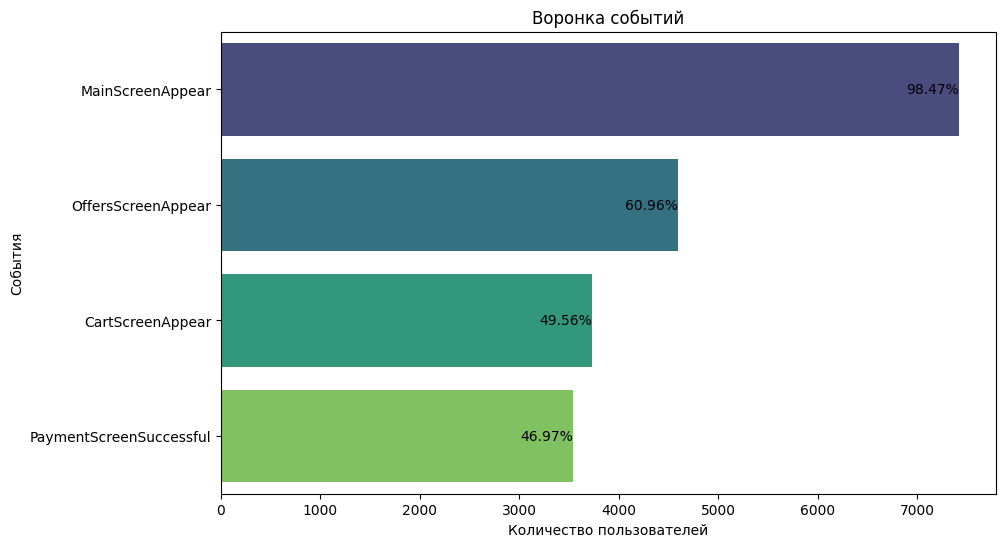

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(x='uniques', y=df_pivot.index, data=df_pivot, palette='viridis')
for index, value in enumerate(df_pivot['uniques']):
    plt.text(value, index, f"{df_pivot['ratio'].iloc[index]}", va='center', ha='right', color='black', fontsize=10)
    plt.title('Воронка событий')
plt.xlabel('Количество пользователей')
plt.ylabel('События')
plt.show()

46,97% от общего количества уникальных пользователей хотя бы раз прошли от главного экрана до совершенной оплаты.

## Изучение результатов эксперимента

In [21]:
df.groupby('exp_id')['device_id_hash'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

Навскидку группы примерно равны, но лучше изучить дополнительные критерии, чтоб убедиться, что значимая разница отсутствует.

Некоторые критерии успешного A/A-теста: 
- попавший в одну из групп посетитель остаётся в этой группе до конца теста
- количество пользователей в группах различается не более, чем на 1-2%<br><br>

В ходе предобработки уже было установлено, что пользователи не перемещаются из группы в группу. Оценю разницу в количестве уникальных пользователей.

In [22]:
unique_counts = df.groupby('exp_id')['device_id_hash'].nunique()
diff = (((unique_counts.get(246, 0)) - (unique_counts.get(247, 0))) / (unique_counts.get(247, 0))) * 100
print(f"Разница между группами 246 и 247: {diff:.2f}%")

Разница между группами 246 и 247: -1.15%


### Проведение А/А теста

Для начала возьму самое популярное событие - MainScreenAppear и посчитаю число пользователей, совершивших это событие в каждой из контрольных групп, а также долю пользователей, совершивших это событие.

In [23]:
msa_event = df.query('event_name == "MainScreenAppear"')
msa_table = msa_event.pivot_table(index='exp_id', values='device_id_hash', aggfunc='nunique')
total_users = df.pivot_table(index='exp_id', values='device_id_hash', aggfunc='nunique')
msa_table.columns = ['uniques']
total_users.columns = ['total']
msa_table = msa_table.join(total_users)
msa_table['ratio'] = (msa_table['uniques'] / msa_table['total'] * 100).apply(lambda x: f"{x:.2f}%")
msa_table

,uniques,total,ratio
exp_id,,,
246,2450,2484,98.63%
247,2476,2513,98.53%
248,2493,2537,98.27%


Теперь проведу тест, чтобы определить наличие либо отсутствие статистически значимой разницы в А/А-группах. Для этого:
- посчитаю количество уникальных пользователей, совершивших данное событие в каждой группе 
- посчитаю количество уникальных пользователей в группах
- вычислю пропорции успехов (совершения события)
- вычислю пропорцию успехов в комбинированном датасете и разницу пропорций для оценки дисперсии при проведении Z-теста 
- посчитаю статистику

**H0:** Доли уникальных пользователей в группах 246 и 247 при совершении события MainScreenAppear одинаковы, поведение групп не отличается.<br>
**H1:** Доли уникальных пользователей в группах 246 и 247 при совершении события MainScreenAppear различны, поведение групп отличается.<br>

In [24]:
alpha = .05
group_246 = df.query('exp_id == 246')
group_247 = df.query('exp_id == 247')
unique_event_246 = group_246.query('event_name == "MainScreenAppear"')['device_id_hash'].nunique()
unique_event_247 = group_247.query('event_name == "MainScreenAppear"')['device_id_hash'].nunique()
total_unique_246 = group_246['device_id_hash'].nunique()
total_unique_247 = group_247['device_id_hash'].nunique()
event_array = np.array([unique_event_246, unique_event_247])
total_array = np.array([total_unique_246, total_unique_247])
p1 = event_array[0] / total_array[0]
p2 = event_array[1] / total_array[1]
p_combined = (event_array[0] + event_array[1]) / (total_array[0] + total_array[1])
difference = p1 - p2
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / event_array[0] + 1 / event_array[1]))
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print(f"P-value: {p_value:.4f}")
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

P-value: 0.7587
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Тест показывает, что разницы в поведении А/А-групп не наблюдается. Теперь заверну этот тест в функцию и повторю тестирование при совершении этого и всех оставшихся событий.

In [25]:
def z_test(group_1, group_2, event):
    alpha = .05
    events = np.array(
        [group_1.query('event_name == @event')['device_id_hash'].nunique(), 
         group_2.query('event_name == @event')['device_id_hash'].nunique()])
    users = np.array([group_1['device_id_hash'].nunique(), group_2['device_id_hash'].nunique()])
    p1 = events[0] / users[0]
    p2 = events[1] / users[1]
    p_combined = (events[0] + events[1]) / (users[0] + users[1])
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / events[0] + 1 / events[1]))
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print(event)
    print(f"P-value: {p_value:.4f}")
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    print()

In [26]:
events_array = df['event_name'].unique()
for event in events_array:
    z_test(group_246, group_247, event)

Tutorial
P-value: 0.9791
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear
P-value: 0.7587
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
P-value: 0.3659
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
P-value: 0.3943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
P-value: 0.2784
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Тест указывает на отсутствие статистически значимой разницы между А/А-группами, следовательно разбивку можно считать корректной.

### Проведение А/B теста

Теперь перейду к группе, которая наблюдала изменённый шрифт. Сравню результаты с каждой из контрольных групп в отдельности по каждому событию.

In [29]:
group_248 = df.query('exp_id == 248')
for event in events_array:
    z_test(group_246, group_248, event)

Tutorial
P-value: 0.9418
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear
P-value: 0.2987
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
P-value: 0.3250
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
P-value: 0.2147
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
P-value: 0.3903
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Значимой разницы в поведении групп 246 и 248 нет.

In [30]:
for event in events_array:
    z_test(group_247, group_248, event)

Tutorial
P-value: 0.9207
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear
P-value: 0.4623
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
P-value: 0.9376
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
P-value: 0.6978
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
P-value: 0.8195
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Значимой разницы в поведении групп 247 и 248 нет.

In [31]:
group_246_247 = pd.concat([group_246, group_247])
for event in events_array:
    z_test(group_246_247, group_248, event)

Tutorial
P-value: 0.9207
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear
P-value: 0.2982
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
P-value: 0.5425
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
P-value: 0.3498
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
P-value: 0.7202
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Значимой разницы в поведении объединённых групп 246 и 247 и группы 248 нет.

### Уровень значимости

В данной работе для проверки статистических гипотез был выбран уровень значимости α = 0.05.<br>
При проведении А/А/B теста было совершено 20 проверок статистических гипотез, что является множественной проверкой. Вероятность совершить хотя бы одну ошибку первого рода при 20 проверках составляет примерно 64%.<br><br>
Для корректировки уровня значимости при множественных проверках можно использовать такие методы, как коррекция Бонферрони или метод Шидака:<br><br>
Поправка Бонферрони: α / m = 0.05 / 20 = 0.0025<br>
Метод Шидака: 1 - (1 - α)^1/m = 0.0025<br><br>

Для того, чтоб при 20 проверках получить желаемую вероятность ошибки первого рода в 0.05, при проведении каждого теста следует установить α = 0.0025

## Общий вывод

Целями проекта были:
1. **Изучить воронку событий:** 
- определить распределение пользователей по шагам воронки
- выявить шаги, на которых теряется больше всего пользователей
2. **Провести эксперимент, определяющий влияние новых шрифтов на поведение пользователей.**

### Воронка событий

- Самое популярное событие - посещение главной страницы: 7419 уникальных пользователей и 98.47% от общего количества уников. Следовательно только 1,53% пользователей попадают на сайт, минуя главную. Следует дополнительно проанализировать источник трафика этих пользователей и тип страниц, на которые они переходят. Возможно, следует привлекать пользователей сразу на отдельные карточки товаров.
- Только лишь 61% пользователей переходит с главного экрана на карточки товаров. Это может говорить о том, что на главном экране существует какая-то проблема, отталкивающая посетителей от совершения дальнейших действий по цепочке.
- 81% пользователей, открывших карточку товара, в последствии переходят в корзину. Это говорит о том, что в целом магазин чаще всего способен дать интересное пользователю предложение.
- Только 5% пользователей, добавивших товар в корзину, уходят не оплатив его, что ещё раз указывает на предложение, которое кажется пользователю привлекательным.
- Лишь 11% посещают раздел с разъясняющей информацией. Возможно, следует дополнительно переработать этот раздел и продумать как он поможет повысить конверсию между 1 и 2 шагами.
- Только 47% пользователей, попадающих на главную страницу, доходят до совершения покупки и большая часть из них отсекается сразу на главной странице.

### Результаты теста

A/А-тест показал корректность разделения пользователей на группы, а A/B не обнаружил статистически значимых различий между контрольными группами. Следовательно, можно говорить о том, что новый шрифт не оказал влияния на поведение пользователей. С этой точки зрения однозначно ответить на вопрос, какой из шрифтов лучше, нельзя.